# EDA for training dataset

data: https://www.kaggle.com/datasets/allanjackson/rossmann


check also the walmart dataset 

In [ ]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.5 MB/s 
     |████████████████████████████████| 9.8 MB 21.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
! pip install statsmodels 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install pystan==2.19.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.4 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 45 kB 2.4 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6641178 sha256=b44430850d8ff08e7f844a4c87e6804e56dbfa40c1b62efc9032c2499e917283
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from matplotlib.cbook import boxplot_stats

import time 
import datetime
from datetime import timedelta
from datetime import datetime

import statsmodels.tsa.api as smt
import statsmodels.tsa as tsa
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

import pmdarima as pm
from pmdarima.arima import auto_arima



In [ ]:
train_data_source ='https://raw.githubusercontent.com/AshrafHabromman/Rossmann_Sales_Forecasting/main/data/train.csv'
train_data_l = r'data\train.csv'
df_train = pd.read_csv(train_data_source, index_col = ['Store', 'Date'], parse_dates = True,)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_train.head() 

,,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,Date,,,,,,,
1,2015-07-31,5,5263,555,1,1,0,1
2,2015-07-31,5,6064,625,1,1,0,1
3,2015-07-31,5,8314,821,1,1,0,1
4,2015-07-31,5,13995,1498,1,1,0,1
5,2015-07-31,5,4822,559,1,1,0,1


In [ ]:
df_train['DayOfWeek'] = df_train.index.get_level_values('Date').dayofweek
df_train['Week'] = df_train.index.get_level_values('Date').week 
df_train['month'] = df_train.index.get_level_values('Date').month
df_train['year'] = df_train.index.get_level_values('Date').year
df_train['dayofyear'] = df_train.index.get_level_values('Date').dayofyear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [ ]:
store_data_source = 'https://raw.githubusercontent.com/AshrafHabromman/Rossmann_Sales_Forecasting/main/data/store.csv'
store_data_l = r'data\store.csv'
df_store = pd.read_csv(store_data_source)
df_store.head()


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
df_train.sort_index(level=1, ascending=True, inplace=True)
df_train.head()

,,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Week,month,year,dayofyear
Store,Date,,,,,,,,,,,
1,2013-01-01,1,0,0,0,0,a,1,1,1,2013,1
2,2013-01-01,1,0,0,0,0,a,1,1,1,2013,1
3,2013-01-01,1,0,0,0,0,a,1,1,1,2013,1
4,2013-01-01,1,0,0,0,0,a,1,1,1,2013,1
5,2013-01-01,1,0,0,0,0,a,1,1,1,2013,1


Check the categorical features  

In [ ]:
# ind = pd.Series(1, index = df_train.loc[1,:].index).asfreq('D')
# indNa = ind[ind.isnull()].index
# len(indNa)

stores = df_train.groupby('Store')
stores_have_miss= {}
for store_num, store in stores:
    
    index = pd.Series(1, index = df_train.loc[store_num,:].index).asfreq('D')
    index_miss = index[index.isnull()].index
    first_miss = True
    if len(index_miss) != 0: 
        if first_miss: 
            prev_index_miss = index_miss
            total_index = index_miss
            first_miss = False
        new_index_date = total_index.difference(index_miss)
        total_index.append(new_index_date)
        total_index.sort_values()
        prev_index_miss = index_miss
        stores_have_miss[store_num] = len(index_miss)
#         stores_have_nan['num_missing'] = len(indNa)
        
        
stores_have_miss

{13: 184,
 20: 184,
 22: 184,
 32: 184,
 36: 184,
 41: 184,
 46: 184,
 51: 184,
 52: 184,
 58: 184,
 72: 184,
 76: 184,
 81: 184,
 89: 184,
 99: 184,
 100: 184,
 108: 184,
 113: 184,
 115: 184,
 127: 184,
 129: 184,
 132: 184,
 136: 184,
 137: 184,
 139: 184,
 144: 184,
 145: 184,
 149: 184,
 155: 184,
 159: 184,
 164: 184,
 165: 184,
 172: 184,
 174: 184,
 181: 184,
 183: 184,
 186: 184,
 190: 184,
 191: 184,
 192: 184,
 204: 184,
 215: 184,
 218: 184,
 231: 184,
 243: 184,
 258: 184,
 263: 184,
 275: 184,
 277: 184,
 279: 184,
 283: 184,
 284: 184,
 287: 184,
 288: 184,
 298: 184,
 306: 184,
 317: 184,
 342: 184,
 345: 184,
 348: 184,
 365: 184,
 385: 184,
 399: 184,
 407: 184,
 412: 184,
 413: 184,
 420: 184,
 427: 184,
 428: 184,
 429: 184,
 430: 184,
 434: 184,
 457: 184,
 471: 184,
 477: 184,
 485: 184,
 490: 184,
 492: 184,
 498: 184,
 500: 184,
 501: 184,
 512: 184,
 514: 184,
 518: 184,
 522: 184,
 534: 184,
 539: 184,
 540: 184,
 542: 184,
 547: 184,
 555: 184,
 571: 184,
 57

In [ ]:
df_train.drop(stores_have_miss, axis='index',inplace=True)
# df_store.drop(stores_have_miss, axis='index', inplace=True)
# train_store.drop(stores_have_miss, axis='index', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


### Check Stationarity by ADFuller for all stores 

In [ ]:
df_train_sales = df_train['Sales'].unstack(level=0)

In [ ]:
df_train_sales.isnull().sum().sum()

1

In [ ]:
df_train_sales.fillna(method='bfill', axis=0, inplace=True)

In [ ]:
all_not_stationary = True
store_have_stationarity = []
store_not_have_stationarity = []
for col in df_train_sales.columns:
#     df_train_sales[col]
    adf_test= adfuller(df_train_sales[col])
    adf_val = adf_test[0]
    p_val = adf_test[1]
    if(p_val > 0.05):
        all_not_stationary = False
        store_have_stationarity.append(col)
        continue
    store_not_have_stationarity.append(col)
#         break;
        
print(all_not_stationary)


False


In [ ]:
print('Number of stors that have statinarity:',len(store_have_stationarity))
print(store_have_stationarity)

Number of stors that have statinarity: 24
[91, 103, 122, 274, 299, 305, 353, 406, 453, 523, 530, 554, 578, 663, 676, 685, 732, 789, 827, 885, 905, 931, 1081, 1086]


- Cells above shows that 24 store have stationarity and the rest of stores does not have stationarity 

### Pre-processing Data

In [ ]:
def do_lags(df, num_lags):
  return pd.concat(
      {
          f'lag_{i}': df.shift(i, fill_value=0)
          for i in range(1,num_lags+1)
      },
      axis=1
  )

def pre_process_store(df, store_num, future_days):

  store_data = df.loc[store_num,:]
  store_pre_processed = pd.DataFrame(index=store_data.index, )

  store_pre_processed = pd.get_dummies(store_data['DayOfWeek'], prefix='DayOfWeek')

  stat_dums = pd.get_dummies(store_data['StateHoliday'], prefix='StateHoliday').drop('StateHoliday_0', axis='columns')
  store_pre_processed = store_pre_processed.join(stat_dums)

  stat_dums_shifted = stat_dums.shift(1, axis='columns', fill_value=0)
  new_cols = {col : f'{col}_shifted_1' for col in stat_dums.columns}
  stat_dums_shifted.rename(columns=new_cols, inplace=True)
  store_pre_processed = store_pre_processed.join(stat_dums_shifted)

  store_data['DayOfWeek'] = (store_data['DayOfWeek']+1) % 7 
  data_to_scale = store_data[['DayOfWeek', 'Week',	'month', 'year', 'dayofyear']]
  
  min_max_scaler = MinMaxScaler()
  scaled_data = min_max_scaler.fit_transform(data_to_scale)

  scaled_data = pd.DataFrame(scaled_data, index=data_to_scale.index, columns=data_to_scale.columns )
  store_pre_processed = store_pre_processed.join(scaled_data)  

  store_sales_rolling_std = store_data['Sales'].rolling(window=7, center=False, min_periods=1).std().fillna(0) # set rolling to the right 
  store_sales_rolling_std = store_sales_rolling_std.to_frame()
  store_sales_rolling_std.rename(columns={'Sales':'Sales_std'}, inplace=True)
  
  store_sales_rolling_mean = store_data['Sales'].rolling(window=7, center=False, min_periods=1).mean().fillna(0)
  store_sales_rolling_mean = store_sales_rolling_mean.to_frame()
  store_sales_rolling_mean.rename(columns={'Sales':'Sales_mean'}, inplace=True)

  store_sales_rolling_std = store_sales_rolling_std.shift(1).fillna(0)
  store_sales_rolling_mean = store_sales_rolling_mean.shift(1).fillna(0)

  store_pre_processed = store_pre_processed.join(store_sales_rolling_std)
  store_pre_processed = store_pre_processed.join(store_sales_rolling_mean)

  y = store_data[['Sales']]

  lags = do_lags(y, 7)
  store_pre_processed = store_pre_processed.join(lags)

  target = pd.DataFrame(index=y.index)
  for i in range(1,future_days+1):
    y_step_ = y.shift(-i).fillna(method='ffill')
    y_step_ = y_step_.rename(columns = {'Sales':f'Sales_shifted_up_{i}'})
    # display(y_step_)
    target = target.join(y_step_)

  y = y.join(target)

  store_pre_processed = store_pre_processed.join(store_data[['Promo','Open']])

  return store_pre_processed, y 

# x, y = pre_process_store(df_train, store_num)
# x.head()


### Split data To train and test 

In [ ]:
train_until = datetime(2015,4,30)

In [ ]:
def train_test_split(x, y, train_until):

  x_train = x.loc[:train_until,:]
  x_test = x.loc[train_until+timedelta(days=1):,:]

  y_train = y[:train_until]         
  y_test = y[train_until+timedelta(days=1):]

  return x_train, x_test, y_train, y_test

# train_stores = df_train_sales.loc[:train_until, :]
# test_stores = df_train_sales.loc[train_until:, :]

# store_data_train = store_data.loc[:train_until, :]
# store_data_train_y = store_data_train['Sales']
# store_data_train_x = store_data_train.drop('Sales', axis=1)

# store_data_test= store_data.loc[train_until+timedelta(days=1):, :]
# store_data_test_y = store_data_test['Sales']
# store_data_test_x = store_data_test.drop('Sales', axis=1) 


### Functions 

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1y") / pd.Timedelta("1d")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [ ]:
def train_arima(train_set, test_set, model):
    start_time = time.time()
    
    model_fit = model.fit()
    forecast = model_fit.forecast(len(test_set))

    test_resid = test_set - forecast 

    # rmse = (np.mean(resid**2))**0.5 # root mean squared error 
    # mae = np.mean(abs(resid))

    #     if(i==4)
    #         break
#     print(f'Root mean squared error = {rmse}')
#     print(f'Mean absolute error = {mae}')
    end_time = time.time()
    print(f'Time taken = {end_time - start_time}')
    
    return forecast, test_resid, model_fit 
    

# def plot_info_model(train_set, test_set, y_pred, forecast, resid, store_num):

#   fig, ax = plt.subplots(3,1, figsize=(18,15))
#   # ax[0].figure(figsize=(18,6))
#   ax[0].plot(train_set, )
#   ax[0].plot(y_pred, )
#   ax[0].plot(test_set)
#   ax[0].plot(forecast)
#   ax[0].legend(('Train','y_pred', 'Test', 'Forecast'))
#   ax[0].set_title(f'Sales of store # {store_num} Train/Test/Forecast')

#   # plt.figure(figsize=(18,6))
#   ax[1].plot(test_set)
#   ax[1].plot(forecast)
#   ax[1].legend(('Test', 'Forecast'))
#   ax[1].set_title(f'Sales of store # {store_num} Test/Forecast')

#   # plt.figure(figsize=(18,4))
#   ax[2].plot(resid)
#   ax[2].axhline(0, linestyle='--', color='grey')
#   ax[2].set_title(f'Error of  model for store # {store_num} ')
  
#   plt.show()

#   m=smt.graphics.plot_acf(resid, title='Autocorrelation for residuals')


def plot_info_model(y_true_train, y_pred_train, y_true_test, y_pred_test, store_num, every=1):

  if isinstance(y_true_train, pd.Series):
    y_true_train = y_true_train.to_frame(name='Sales')
  if isinstance(y_pred_train, pd.Series):
    y_pred_train = y_pred_train.to_frame(name='Sales')
  if isinstance(y_true_test, pd.Series):
    y_true_test = y_true_test.to_frame(name='Sales')
  if isinstance(y_pred_test, pd.Series):
    y_pred_test = y_pred_test.to_frame(name='Sales')
    
  true_color = 'b'
  pred_color = 'r'
  fig, ax = plt.subplots(3,1, figsize=(18,15))

  plt.subplots_adjust(hspace=0.5,)

  ax[0].plot(y_true_train.iloc[:,0], color=true_color)

  for date, preds in y_pred_train[::every].iterrows():
    preds.index = pd.period_range(start=date, periods=len(preds))
    preds.plot(ax=ax[0], color=pred_color)
  ax[0].legend(('Train','y_pred'))
  ax[0].set_title(f'Sales of store # {store_num} Train/Pred')

  # plt.figure(figsize=(18,6))

  ax[1].plot(y_true_test.iloc[:,0], color=true_color)
  for date, preds in y_pred_test[::every].iterrows():
    preds.index = pd.period_range(start=date, periods=len(preds))
    preds.plot(ax=ax[1],color=pred_color)
  ax[1].legend(('Test', 'Forecast'))
  ax[1].set_title(f'Sales of store # {store_num} Test/Forecast')

  # plt.figure(figsize=(18,4))

  for date, true in y_true_test[::every].iterrows():
    pred = y_pred_test.loc[date,:]
    resid = true - pred 
    resid.index = pd.period_range(start=date, periods=len(preds))
    resid.plot(ax=ax[2], color='g')

  ax[2].axhline(0, linestyle='--', color='grey')
  ax[2].set_title(f'Error of  model for store # {store_num} ')
  
  plt.show()

def plot_autocorr_resid(y_true_train, y_pred_train, y_true_test, y_pred_test):

  fig, ax = plt.subplots(len(y_true_train.columns), 2, figsize=(12, 4*len(y_true_train.columns)))

  i=0
  for col in y_true_train.columns:
    train_resid_ = y_true_train[col] - y_pred_train[col] 
    m=smt.graphics.plot_acf(train_resid_,ax=ax[i][0], title=f'Autocorrelation for train residuals / {col}')

    test_resid_ = y_true_test[col] - y_pred_test[col] 
    m=smt.graphics.plot_acf(test_resid_, ax=ax[i][1], title=f'Autocorrelation for test residuals / {col}')
    i+=1
  # m=smt.graphics.plot_acf(resid, title='Autocorrelation for residuals')



In [ ]:
# mae = []
# i=0
# for col in store_have_stationarity: 
#     model = auto_arima(train_stores[col],
#                           start_p=0 , d=0, start_q=0,      # d for difference , data here is stationary - does not have to do differencing
#                           max_p=7, max_q=7,
#                           start_Q=0, max_Q=3,
#                           start_P=0, max_P=3,
#                           m=52,                       # week seasonality 
#                           scoring='mae'
#                          )
#     model.fit(train_stores[col])
#     pred = model.predict(len(test_stores[col]))
#     resid = test_stores[col] - pred 
#     mae.append(np.mean(abs(resid)))
#     print(i)
#     i+=1
#     if(i==1):
#       break
    

In [ ]:
# print(mae)

In [ ]:

# start_time = time.time()
# i=0
# # for col in store_not_have_stationarity:
    

# model_fit = model.fit()
# pred = model_fit.forecast(len(test_stores[1]))

# resid = test_stores[1] - pred 

# rmse = (np.mean(resid**2))**0.5 # root mean squared error 
# mae = np.mean(abs(resid))

# #     if(i==4)
# #         break
# print(f'Root mean squared error = {rmse}')
# print(f'Mean absolute error = {mae}')
# end_time = time.time()
# print(f'Time taken = {end_time - start_time}')


#### Evaluation function

In [ ]:
def mean_corr(y_true, y_pred):
  if isinstance(y_true, pd.DataFrame):
    corrs = []
    for col in y_true.columns: 
      # print(col)
      corr = y_true[col].corr(y_pred[col])
      corrs.append(corr)
    return np.mean(corrs)

  else: return y_true.corr(y_pred)

def evaluate(y_true_train, y_pred_train, y_true_test, y_pred_test):

  print(f'>>>>>>>> Evaluation metrics for Train <<<<<<<<')
  print(f'Root mean squared error  = {mean_squared_error(y_true_train, y_pred_train, squared=False):.2f}')
  print(f'Mean absolute error = {mean_absolute_error(y_true_train, y_pred_train):.2f}')
  print(f'Mean of residual = {np.mean(np.mean(y_true_train - y_pred_train)):.2f}')
  print(f'Correlation = {mean_corr(y_true_train, y_pred_train):.2f}\n')

  print(f'>>>>>>>> Evaluation metrics for Test <<<<<<<<<')
  print(f'Root mean squared error = {mean_squared_error(y_true_test, y_pred_test, squared=False):.2f}')
  print(f'Mean absolute error = {mean_absolute_error(y_true_test, y_pred_test):.2f}')
  print(f'Mean of test residual = {np.mean(np.mean(y_true_test - y_pred_test)):.2f}') 
  print(f'Correlation = {mean_corr(y_true_test, y_pred_test):.2f}')


# Prophet 

In [ ]:
class ProphetWith:
  def __init__(self, model, holidays,future_days):
    self.model_1 = None
    self.model_2 = model
    self.holidays = holidays
    self.future_days = future_days

  def fit(self, x_train, y_train):
    y_train_pro = y_train['Sales'].to_frame()
    y_train_pro.reset_index(inplace=True)
    y_train_pro = y_train_pro.rename(columns={'Date':'ds', 'Sales':'y'})

    start = time.time()

    self.model_1 = Prophet(holidays=self.holidays)
    
    self.model_1.fit(y_train_pro)
    y_train_pred = self.model_1.predict(self.model_1.make_future_dataframe(periods=0))['yhat']

    if(self.model_2 != None):

      y_train_pred = y_train_pred.to_frame(name='Sales')
      # display(train_resid)
      # display(y_train_pred)
      y_train_pred.index = y_train.index
      y_pred_shifted = pd.DataFrame(index=y_train.index)

      for i in range(1,self.future_days+1):
        y_pred_step_ = y_train_pred.shift(-i).fillna(method='ffill')
        y_pred_step_ = y_pred_step_.rename(columns = {'Sales': f'Sales_shifted_up_{i}'} )
        y_pred_shifted = y_pred_shifted.join(y_pred_step_)

      # display(y_pred_shifted)
      y_train_pred = y_train_pred.join(y_pred_shifted)

      train_resid = y_train.values - y_train_pred.values

      self.model_2.fit(x_train, train_resid)

      end = time.time()
      print(f'Time taken : {(end-start)/60} min')
      y_train_pred += self.model_2.predict(x_train)

      self.y_train_pred = y_train_pred
      self.y_train_pred.index = y_train.index
      self.y_train_resid = y_train - y_train_pred
      
      return 

    else:
      end = time.time()
      print(f'Time taken : {(end-start)/60} min')
      self.y_train_pred = y_train_pred
      self.y_train_pred.index = y_train.index
      self.y_train_resid = y_train_pro['y'].values - y_train_pred.values
      return 
  def predict(self, x_test, len_y_test):

    future = self.model_1.make_future_dataframe(periods=len_y_test)
    future = future.tail(len_y_test)

    forecast = self.model_1.predict(future)['yhat']
    if(self.model_2 != None):

      forecast = forecast.to_frame(name='Sales')

      y_fore_shifted = pd.DataFrame(index=forecast.index)
      for i in range(1,self.future_days+1):
        y_fore_step_ = forecast.shift(-i).fillna(method='ffill')
        y_fore_step_ = y_fore_step_.rename(columns = {'Sales': f'Sales_shifted_up_{i}'} )
        # display(y_resid_step_)
        y_fore_shifted = y_fore_shifted.join(y_fore_step_)

      forecast = forecast.join(y_fore_shifted)

      forecast += self.model_2.predict(x_test,)

    forecast.index = x_test.index
    return forecast


### Prophet only 

In [ ]:
store_num = store_not_have_stationarity[0]
future_days = 8
x, y = pre_process_store(df_train, store_num, future_days)
holidays = x[(x['StateHoliday_a']==1) | (x['StateHoliday_b']==1) | (x['StateHoliday_c']==1)].index
holidays = pd.DataFrame({'ds':holidays, 'holiday':'state_holiday'})
x.drop(['StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'], axis='columns', inplace=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_until)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,


### Data That could enter models

In [ ]:
display(x_train.columns)

Index([             'DayOfWeek_0',              'DayOfWeek_1',
                    'DayOfWeek_2',              'DayOfWeek_3',
                    'DayOfWeek_4',              'DayOfWeek_5',
                    'DayOfWeek_6', 'StateHoliday_a_shifted_1',
       'StateHoliday_b_shifted_1', 'StateHoliday_c_shifted_1',
                      'DayOfWeek',                     'Week',
                          'month',                     'year',
                      'dayofyear',                'Sales_std',
                     'Sales_mean',         ('lag_1', 'Sales'),
               ('lag_2', 'Sales'),         ('lag_3', 'Sales'),
               ('lag_4', 'Sales'),         ('lag_5', 'Sales'),
               ('lag_6', 'Sales'),         ('lag_7', 'Sales'),
                          'Promo',                     'Open'],
      dtype='object')

In [ ]:
y_train.columns

Index(['Sales', 'Sales_shifted_up_1', 'Sales_shifted_up_2',
       'Sales_shifted_up_3', 'Sales_shifted_up_4', 'Sales_shifted_up_5',
       'Sales_shifted_up_6', 'Sales_shifted_up_7', 'Sales_shifted_up_8'],
      dtype='object')

In [ ]:

prophet = ProphetWith(None, holidays, future_days)
prophet.fit(x_train, y_train)
forecast = prophet.predict(x_test, len(y_test))
forecast.index = y_test.index

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Time taken : 0.07716796398162842 min


#### Evaluation

In [ ]:
print('Mean of train sales :',np.mean(y_train['Sales']))
print('Mean of test sales :',np.mean(y_test['Sales']))

Mean of train sales : 3976.890588235294
Mean of test sales : 3657.5760869565215


In [ ]:
evaluate(y_train['Sales'], prophet.y_train_pred, y_test['Sales'], forecast)

>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 808.44
Mean absolute error = 635.44
Mean of residual = -0.12
Correlation = 0.92

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 663.64
Mean absolute error = 548.59
Mean of test residual = -74.14
Correlation = 0.94


#### Autocorrelation for residuals

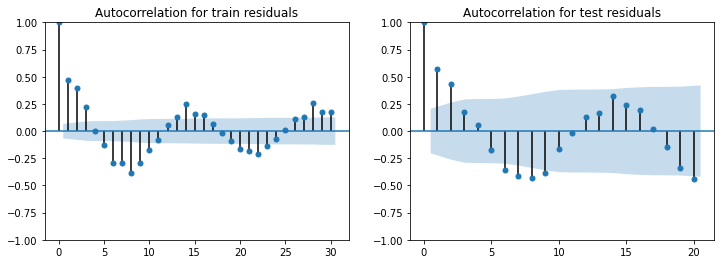

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
train_resid = y_train['Sales'] -  prophet.y_train_pred
test_resid = y_test['Sales'] - forecast
l=smt.graphics.plot_acf(train_resid, ax=ax[0], title='Autocorrelation for train residuals')
l=smt.graphics.plot_acf(test_resid, ax=ax[1], title='Autocorrelation for test residuals')

### Prophet boosted with linear regression 

In [ ]:

x, y = pre_process_store(df_train, store_num, future_days)
holidays = x[(x['StateHoliday_a']==1) | (x['StateHoliday_b']==1) | (x['StateHoliday_c']==1)].index
holidays = pd.DataFrame({'ds':holidays, 'holiday':'state_holiday'})
x.drop(['StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'], axis='columns', inplace=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_until)

prophet_with_linearReg = ProphetWith(LinearRegression(), holidays, future_days )
prophet_with_linearReg.fit(x_train, y_train)
forecast = prophet_with_linearReg.predict(x_test, len(y_test))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning

Time taken : 0.06033705075581868 min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


#### Evaluation

In [ ]:
print('Mean of train sales :',np.mean(y_train['Sales']))
print('Mean of test sales :',np.mean(y_test['Sales']))

Mean of train sales : 3976.890588235294
Mean of test sales : 3657.5760869565215


In [ ]:
evaluate(y_train, prophet_with_linearReg.y_train_pred, y_test, forecast, )

>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 717.44
Mean absolute error = 530.30
Mean of residual = 0.00
Correlation = 0.94

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 565.86
Mean absolute error = 456.94
Mean of test residual = -54.89
Correlation = 0.95


#### Plots

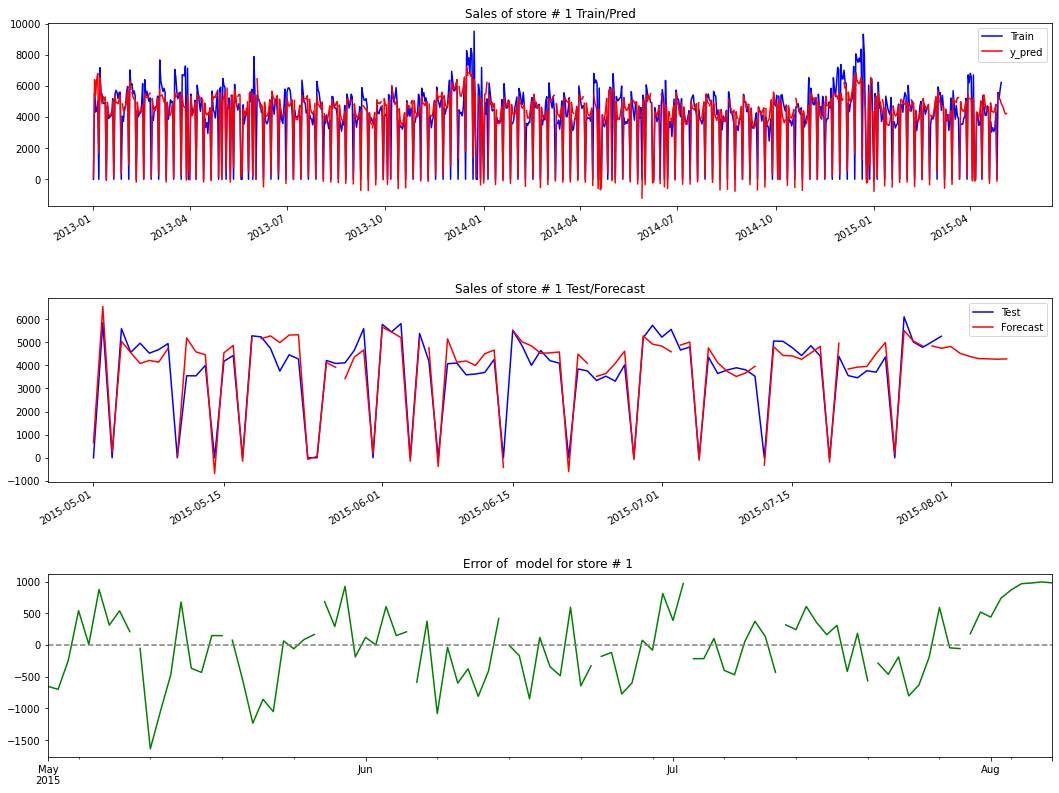

In [ ]:
plot_info_model(y_train, prophet_with_linearReg.y_train_pred, y_test, forecast, store_num, every=len(y_train.columns))

#### Autocorrelation for residuals

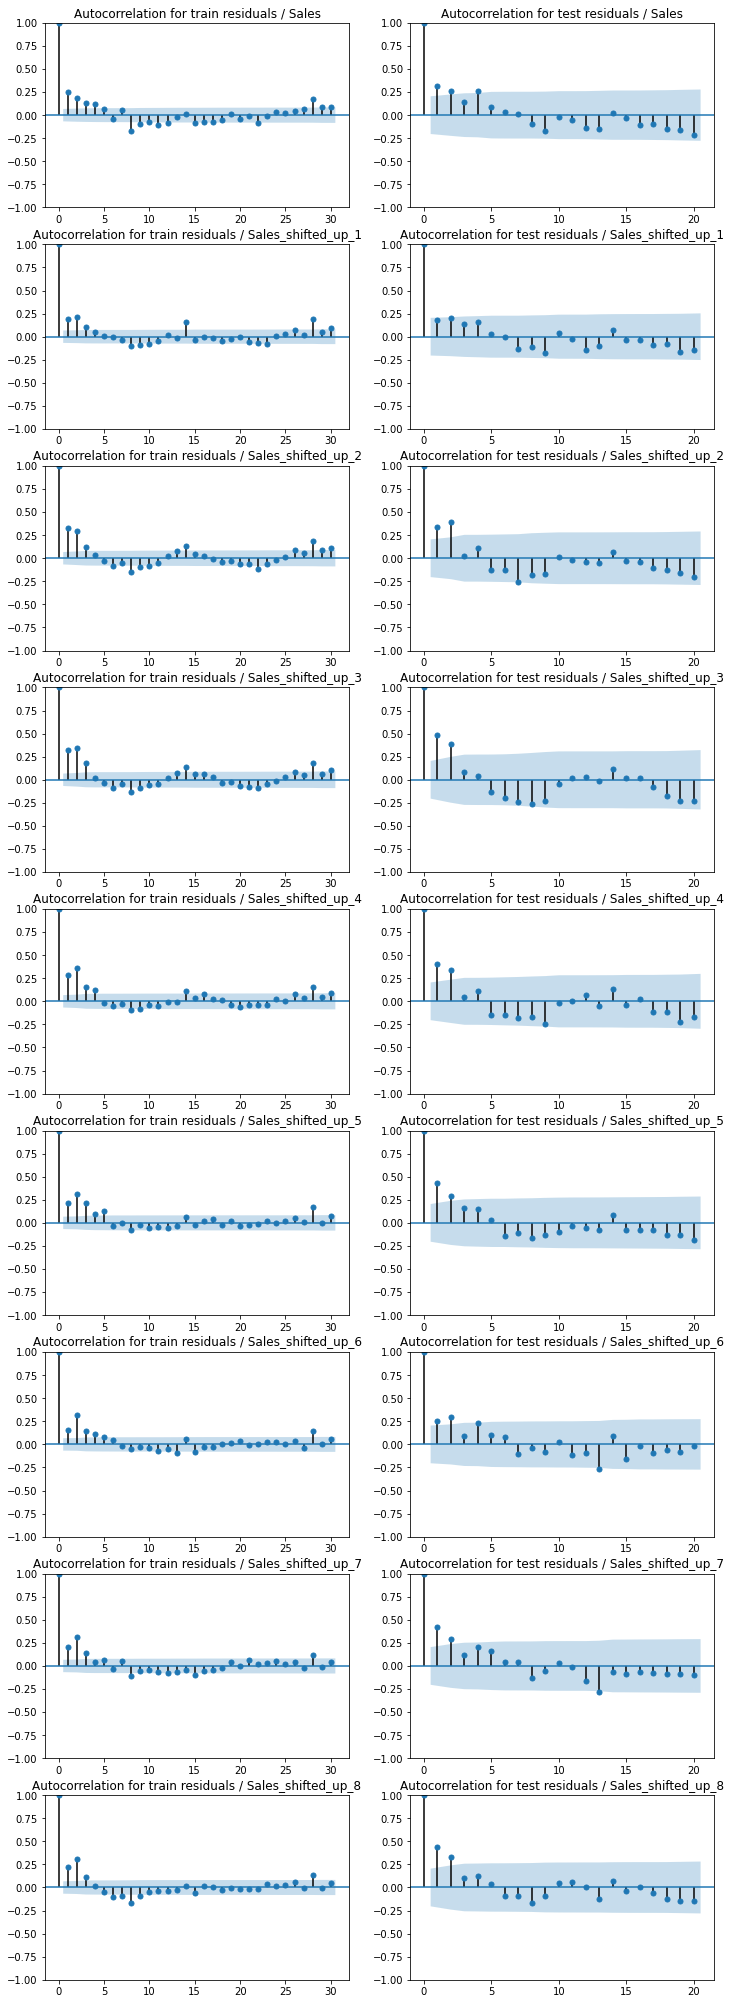

In [ ]:
plot_autocorr_resid(y_train, prophet_with_linearReg.y_train_pred, y_test, forecast)

### Prophet with KNN

In [ ]:

x, y = pre_process_store(df_train, store_num, future_days)
holidays = x[(x['StateHoliday_a']==1) | (x['StateHoliday_b']==1) | (x['StateHoliday_c']==1)].index
holidays = pd.DataFrame({'ds':holidays, 'holiday':'state_holiday'})
x.drop(['StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'], axis='columns', inplace=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_until)

prophet_with_knn = ProphetWith(KNeighborsRegressor(n_neighbors=3), holidays, future_days)
prophet_with_knn.fit(x_train, y_train)
forecast = prophet_with_knn.predict(x_test, len(y_test))

evaluate(y_train, prophet_with_knn.y_train_pred, y_test, forecast)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning

Time taken : 0.05960214932759603 min
>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 536.57
Mean absolute error = 382.97
Mean of residual = 17.64
Correlation = 0.96

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 602.55
Mean absolute error = 467.15
Mean of test residual = -81.47
Correlation = 0.95


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
# m=smt.graphics.plot_acf( y_test.values - forecast.values, title='Autocorrelation for test residual')

### Prophet with DecisionTree 

In [ ]:
x, y = pre_process_store(df_train, store_num, future_days)
holidays = x[(x['StateHoliday_a']==1) | (x['StateHoliday_b']==1) | (x['StateHoliday_c']==1)].index
holidays = pd.DataFrame({'ds':holidays, 'holiday':'state_holiday'})
x.drop(['StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'], axis='columns', inplace=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_until)

prophet_with_decisiontree = ProphetWith(DecisionTreeRegressor(), holidays, future_days)
prophet_with_decisiontree.fit(x_train, y_train)
forecast = prophet_with_decisiontree.predict(x_test, len(y_test))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning

Time taken : 0.06102667649586995 min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


#### Evaluation 

In [ ]:
print('Mean of train sales :',np.mean(y_train['Sales']))
print('Mean of test sales :',np.mean(y_test['Sales']))

Mean of train sales : 3976.890588235294
Mean of test sales : 3657.5760869565215


In [ ]:
evaluate(y_train, prophet_with_decisiontree.y_train_pred, y_test, forecast)

>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 0.00
Mean absolute error = 0.00
Mean of residual = 0.00
Correlation = 1.00

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 778.85
Mean absolute error = 601.42
Mean of test residual = -17.09
Correlation = 0.91


#### Plots

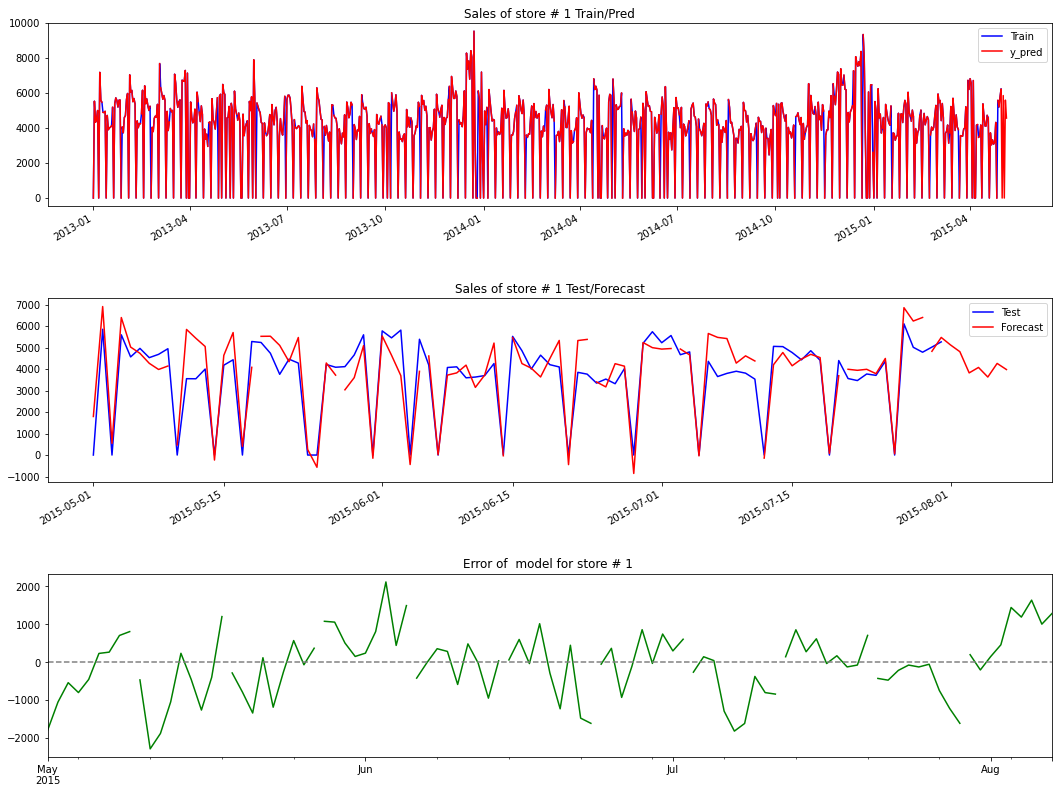

In [ ]:
plot_info_model(y_train, prophet_with_decisiontree.y_train_pred, y_test, forecast, store_num, every= len(y_train.columns))

#### AutoCorrelation

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/p

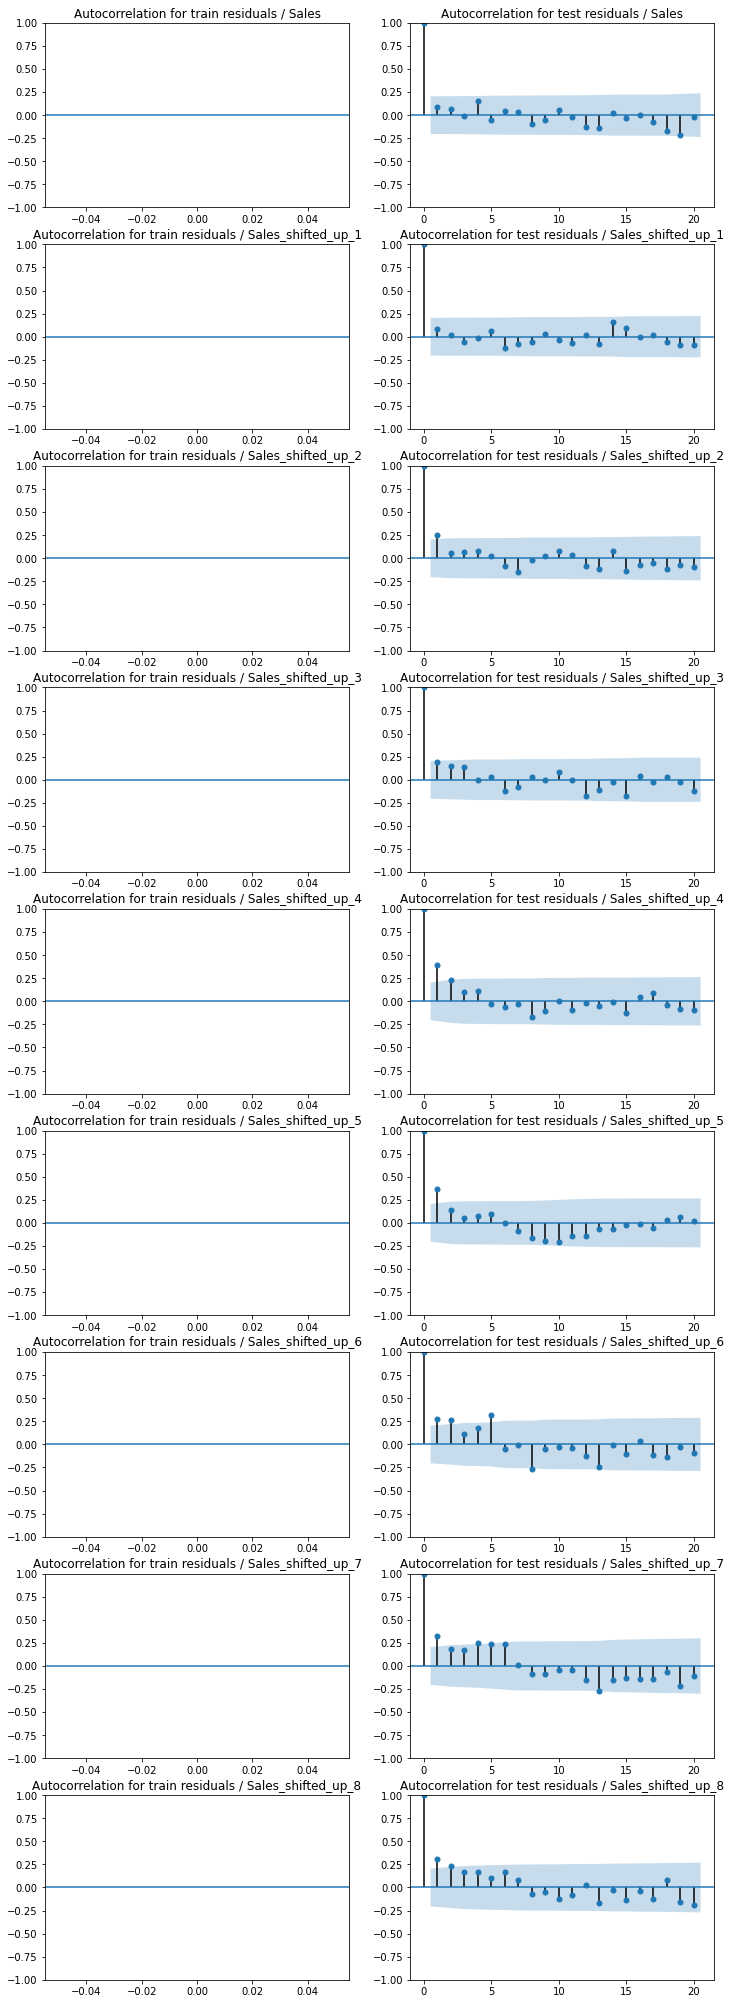

In [ ]:
plot_autocorr_resid(y_train, prophet_with_decisiontree.y_train_pred, y_test, forecast,)

### Prophet with random forest 

In [ ]:

x, y = pre_process_store(df_train, store_num,  future_days)
holidays = x[(x['StateHoliday_a']==1) | (x['StateHoliday_b']==1) | (x['StateHoliday_c']==1)].index
holidays = pd.DataFrame({'ds':holidays, 'holiday':'state_holiday'})
x.drop(['StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'], axis='columns', inplace=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_until)

prophet_with_random_forest = ProphetWith(RandomForestRegressor(), holidays, future_days)
prophet_with_random_forest.fit(x_train, y_train)
forecast = prophet_with_random_forest.predict(x_test, len(y_test))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


Time taken : 0.07363200187683105 min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


#### Evaluation 

In [ ]:
print(f'Mean of train sales : {np.mean(y_train["Sales"]) :.2f}')
print(f'Mean of test sales : {np.mean(y_test["Sales"]) :.2f}')

Mean of train sales : 3976.89
Mean of test sales : 3657.58


In [ ]:
evaluate(y_train, prophet_with_random_forest.y_train_pred, y_test, forecast)

>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 257.36
Mean absolute error = 179.95
Mean of residual = -1.71
Correlation = 0.99

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 510.72
Mean absolute error = 399.57
Mean of test residual = -60.07
Correlation = 0.96


#### Plots

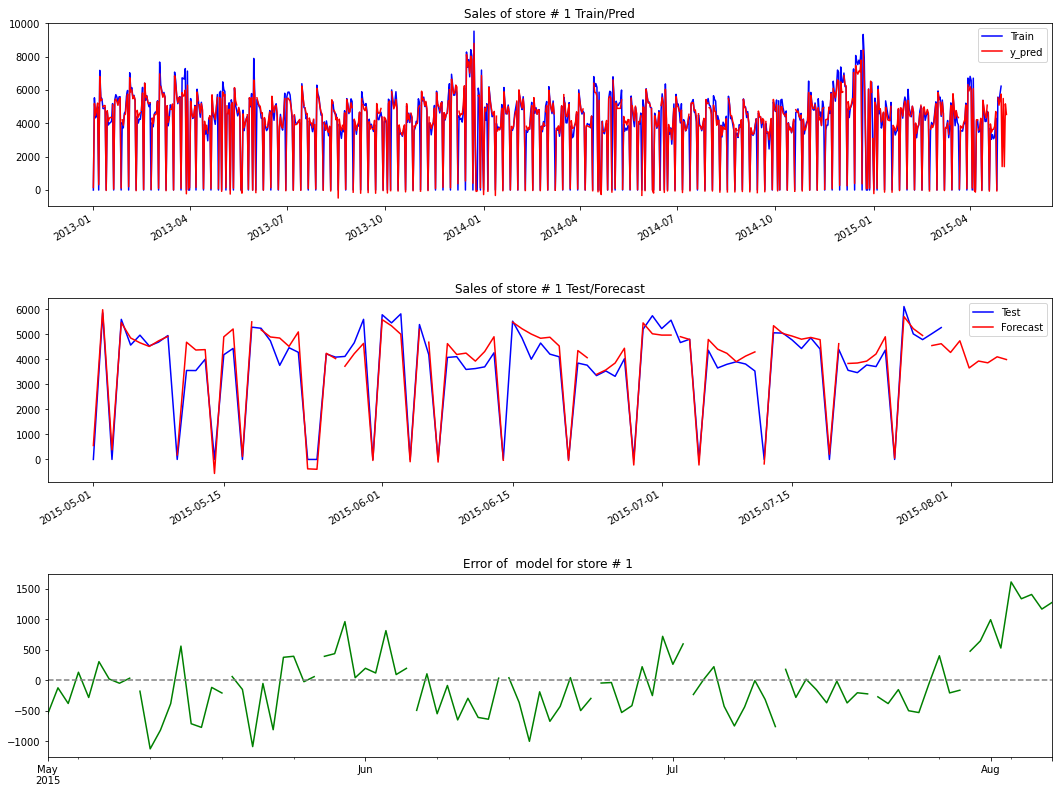

In [ ]:
plot_info_model(y_train, prophet_with_random_forest.y_train_pred, y_test, forecast, store_num, every=len(y_train.columns))

### prophet with xgboost

In [ ]:

x, y = pre_process_store(df_train, store_num, future_days)
holidays = x[(x['StateHoliday_a']==1) | (x['StateHoliday_b']==1) | (x['StateHoliday_c']==1)].index
holidays = pd.DataFrame({'ds':holidays, 'holiday':'state_holiday'})
x.drop(['StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'], axis='columns', inplace=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_until)

prophet_with_xgboost = ProphetWith(MultiOutputRegressor(XGBRegressor()), holidays, future_days)
prophet_with_xgboost.fit(x_train, y_train)
forecast = prophet_with_xgboost.predict(x_test, len(y_test))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[23:56:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

#### Evaluation 

In [ ]:
print('Mean of train sales :',np.mean(y_train['Sales']))
print('Mean of test sales :',np.mean(y_test['Sales']))

Mean of train sales : 3976.890588235294
Mean of test sales : 3657.5760869565215


In [ ]:
evaluate(y_train, prophet_with_xgboost.y_train_pred, y_test, forecast)

>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 448.18
Mean absolute error = 339.13
Mean of residual = 0.14
Correlation = 0.98

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 791.52
Mean absolute error = 652.93
Mean of test residual = 391.41
Correlation = 0.95


In [ ]:
# ----------- Without lags -----------
# Time taken : 0.06360003550847372 min
# Root mean squared error /on train = 380.2549706914496
# Mean absolute error / on train = 295.5460044769992

# Root mean squared error / on test  = 402.75511741324163
# Mean absolute error / on test = 315.0291413465352

# Mean of train residual = 0.2828198252922491
# Mean of test residual = -54.50679383365901

# - ------- without lagas and without std and mean rolling 
# Time taken : 0.08406196037928264 min
# Root mean squared error /on train = 424.6790901466121
# Mean absolute error / on train = 319.98039560033084

# Root mean squared error / on test  = 536.6386525356633
# Mean absolute error / on test = 440.67322625402124

# Mean of train residual = 0.11714613502928414
# Mean of test residual = -357.93100409181113

In [ ]:
# m=smt.graphics.plot_acf( y_test.values - forecast.values, title='Autocorrelation for test residual')

In [ ]:
# forecast.index = y_test.index
# plot_info_model(y_train, y_test, prophet_with_xgboost.y_train_pred, forecast, y_test - forecast, store_num)
# (train_set, test_set, y_pred, forecast, resid, store_num)
# forecast.head()
# y_train.head()
# prophet_with_xgboost.y_train_pred.head()

In [ ]:
# x_train.head()

### Prophet with chain randomforest

In [ ]:

x, y = pre_process_store(df_train, store_num,  future_days)
holidays = x[(x['StateHoliday_a']==1) | (x['StateHoliday_b']==1) | (x['StateHoliday_c']==1)].index
holidays = pd.DataFrame({'ds':holidays, 'holiday':'state_holiday'})
x.drop(['StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c'], axis='columns', inplace=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_until)

prophet_with_random_forest_chain = ProphetWith(RegressorChain(RandomForestRegressor()), holidays, future_days)
prophet_with_random_forest_chain.fit(x_train, y_train)
forecast = prophet_with_random_forest_chain.predict(x_test, len(y_test))
y_train_pred = prophet_with_random_forest_chain.y_train_pred


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


Time taken : 0.2394919753074646 min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


#### Evaluation 

In [ ]:
print('Mean of train sales :',np.mean(y_train['Sales']))
print('Mean of test sales :',np.mean(y_test['Sales']))

Mean of train sales : 3976.890588235294
Mean of test sales : 3657.5760869565215


In [ ]:
evaluate(y_train, prophet_with_random_forest_chain.y_train_pred, y_test, forecast)

>>>>>>>> Evaluation metrics for Train <<<<<<<<
Root mean squared error  = 440.46
Mean absolute error = 281.48
Mean of residual = 30.57
Correlation = 0.97

>>>>>>>> Evaluation metrics for Test <<<<<<<<<
Root mean squared error = 507.80
Mean absolute error = 383.67
Mean of test residual = -33.16
Correlation = 0.96


#### plots

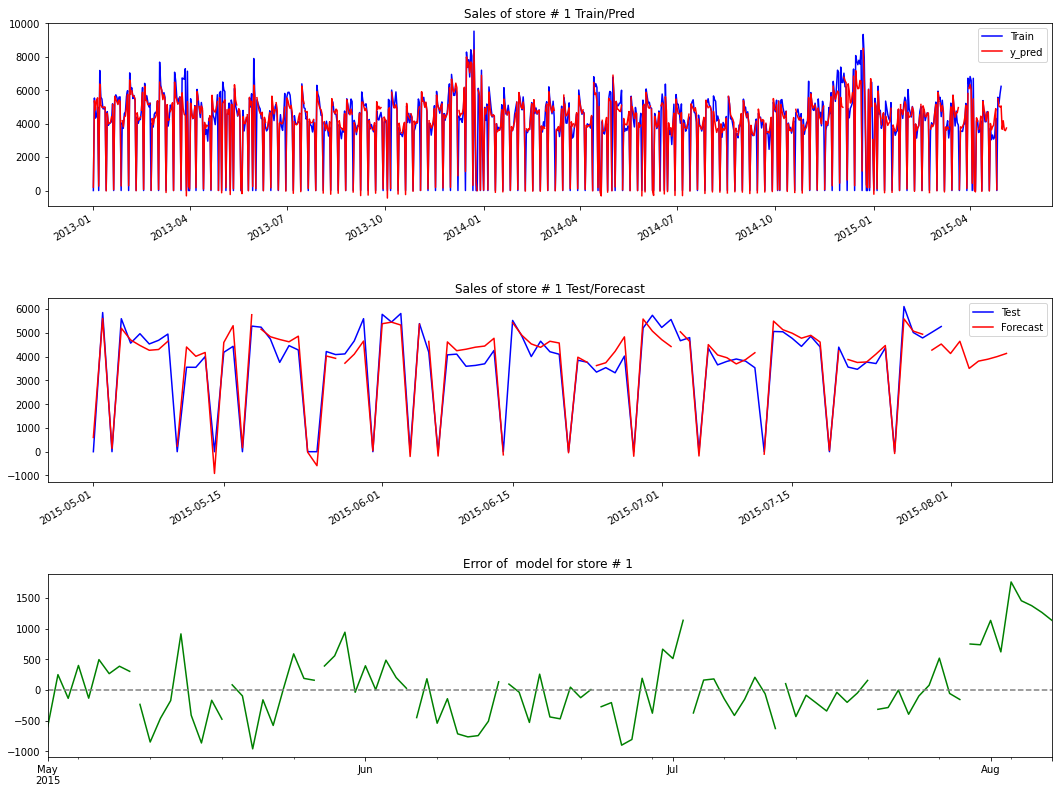

In [ ]:
plot_info_model(y_train, prophet_with_random_forest_chain.y_train_pred, y_test, forecast, store_num, every=len(y_train.columns))

#### Autocorrelation 

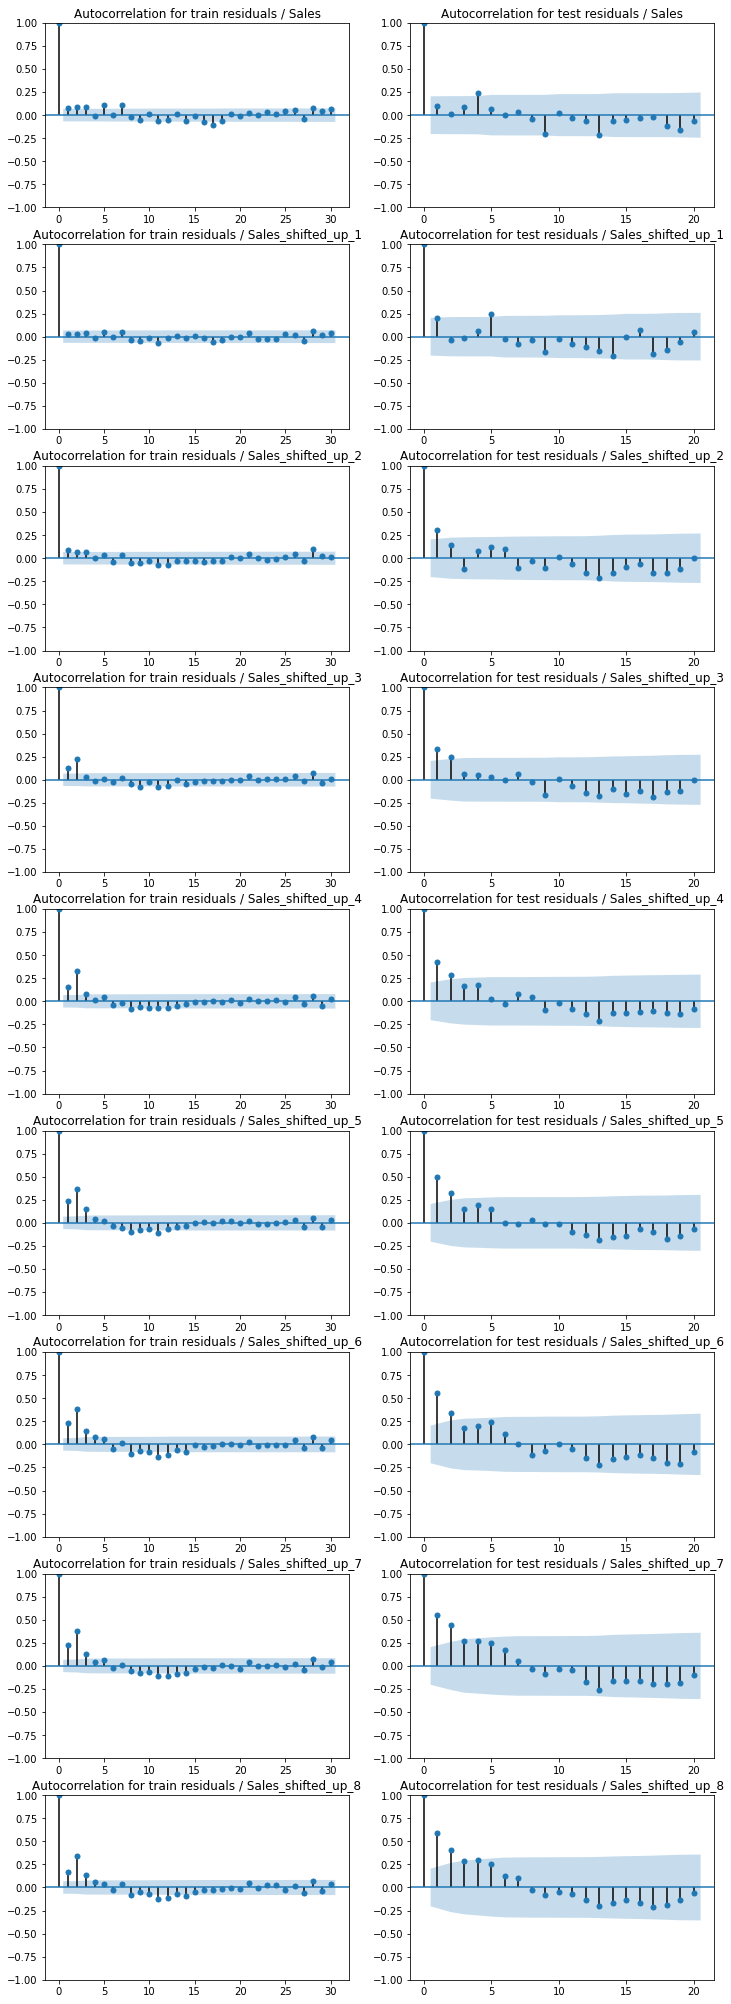

In [ ]:
plot_autocorr_resid(y_train, prophet_with_random_forest_chain.y_train_pred, y_test, forecast)

Mean of train sales : 3976.890588235294

Mean of test sales : 3657.5760869565215

## Breif of Modling 

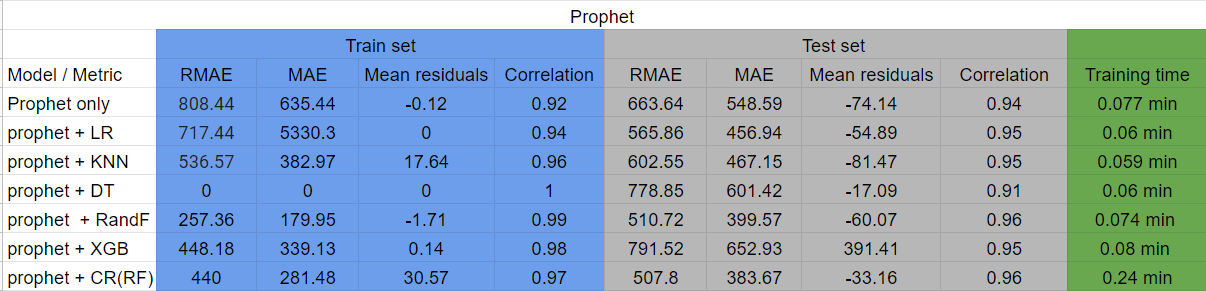